In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
])

# Advanced encoder using ResNet
def create_advanced_encoder():
    inputs = keras.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)
    resnet = keras.applications.ResNet50V2(include_top=False, weights=None, pooling='avg', input_shape=(32, 32, 3))
    outputs = resnet(x)
    return keras.Model(inputs=inputs, outputs=outputs, name="advanced_encoder")

encoder = create_advanced_encoder()
encoder.summary()

# Supervised Contrastive Loss
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature

    def call(self, labels, feature_vectors):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.matmul(feature_vectors_normalized, feature_vectors_normalized, transpose_b=True) / self.temperature
        labels = tf.squeeze(tf.cast(labels, tf.int32))
        return tfa.losses.npairs_loss(labels, logits)

# Learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

# Build full model with projection head
def add_projection_head(encoder_output):
    x = layers.Dense(128, activation="relu")(encoder_output)
    return x

# Modify the model compilation to include accuracy metrics
def build_full_model(encoder):
    inputs = keras.Input(shape=(32, 32, 3))
    encoder_outputs = encoder(inputs)
    projection_outputs = add_projection_head(encoder_outputs)
    outputs = layers.Dense(10, activation='softmax')(projection_outputs)
    full_model = keras.Model(inputs=inputs, outputs=outputs, name="full_model_with_projection_head")
    full_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=SupervisedContrastiveLoss(temperature=0.1),
        metrics=['accuracy']  # Include accuracy metrics here
    )
    return full_model

# Rebuild and retrain the model with metrics included
full_model = build_full_model(encoder)
history_projection = full_model.fit(
    x_train, y_train,
    batch_size=256,
    epochs=2,
    validation_data=(x_test, y_test)
)

# Evaluate the model and extract the accuracy
eval_results = full_model.evaluate(x_test, y_test)
print(f"Test loss: {eval_results[0]}, Test accuracy: {eval_results[1]*100:.2f}%")





/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


170498071/170498071 [==============================] - 3s 0us/step
Model: "advanced_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23564800 (89.89 MB)
Trainable params: 23519360 (89.72 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________
Epoch 1/2
196/196 [==============================] - 3044s 15s/step - loss: 5.5448 - accuracy: 0.1001 - val_loss: 5.5407 - val_accuracy: 0.1000
Epoch 2/2
313/313 [==============================] - 43s 

313/313 [==============================] - 59s 184ms/step


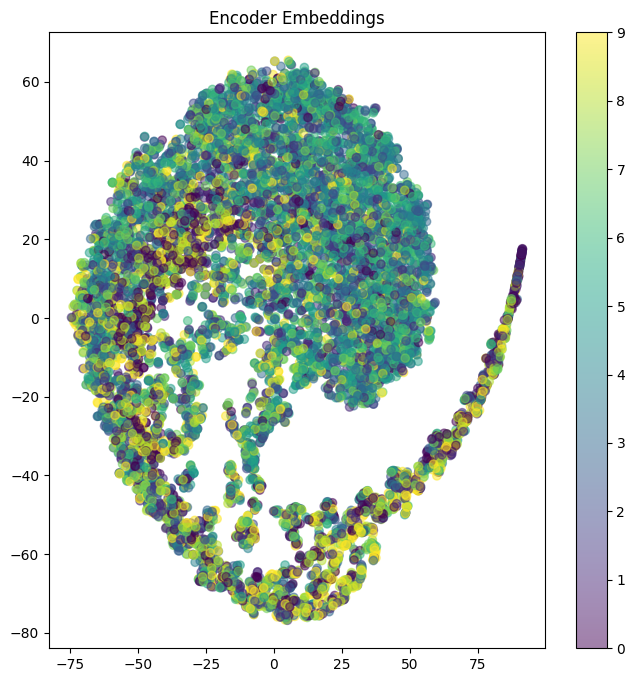

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow import keras

def visualize_embeddings(encoder, data, labels, title="t-SNE Embedding"):


    # Predicting embeddings
    intermediate_output = encoder.predict(data)  # Using encoder to predict directly

    # t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_output)

    # Plotting
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

# Assuming y_test might need flattening
y_test_flat = y_test.flatten() if y_test.ndim > 1 else y_test

# Call the visualization function
visualize_embeddings(encoder, x_test, y_test_flat, title="Encoder Embeddings")
